In [1]:
%cd ..

/Users/peli/Projects/Repositories/DDM-NumEstPark


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import graphviz
import seaborn as sns
from datetime import datetime
from src.model import build_subject_model, build_hierarchical
from src.utils import get_paths

In [3]:
def get_sub_paths():
    """
    Return a list of all file paths of csv data
    """
    dir = "data"
    base = Path.cwd()
    data_dir = base / dir
    data_files = list(data_dir.glob('*.csv'))
    print(f"data_files {data_files}")
    return data_files

def get_subject_data():
    files = get_sub_paths()
    file = files[0]
    df = pd.read_csv(file)
    print(df.head(5))
    subject_df = df[df["S_ID"] == "S_00"]

    x_stim = subject_df["Presented_numerosity"]
    y_obs = subject_df["Estimated_numerosity"]

    print(f"Length n_stim {len(x_stim)}")
    print(f"n_stim: {x_stim.value_counts().sort_index()}")
    print(f"Length y_obs {len(y_obs)}")
    print(f"y_obs: {y_obs.value_counts().sort_index()}")
    return x_stim, y_obs

def get_all_data(
        subset_prop: float | None = None
):
    path = get_paths("dataset", "*")

    df = pd.read_csv(path)
    

    if subset_prop:
        assert 0 < subset_prop < 1
        np.random.seed(89)
        # Get unique subject IDs
        unique_subjects = df["S_ID"].unique()
        # Randomly sample ~20% of subjects
        n_subset = max(1, int(subset_prop * len(unique_subjects)))  # at least 1 subject
        sampled_subjects = np.random.choice(
            unique_subjects, 
            size=n_subset, 
            replace=False
        )
        # Filter dataframe to only those subjects
        df = df[df["S_ID"].isin(sampled_subjects)].reset_index(drop=True)

    X = df
    

    return X



In [4]:
get_all_data(subset_prop=0.5)

data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list


,S_ID,s_param_id_code,Trial,Seed,Delay,Presented_numerosity,Estimated_numerosity,Response_time,Duration_Display,s_param_PD_diagnostic,...,s_param_PD_side,s_duration_PD,s_answer_Q1,s_answer_Q2,s_answer_Q3,s_answer_Q4,s_age,s_gender,entity,dose
0,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,41,57,500,5,5,3560,264,PD,...,right,150,0,0,0,0,70,male,object,1000.0
1,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,42,58,500,8,10,4211,264,PD,...,right,150,0,0,0,0,70,male,object,1000.0
2,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,43,75,500,7,8,2992,265,PD,...,right,150,0,0,0,0,70,male,object,1000.0
3,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,44,7,500,6,8,2563,262,PD,...,right,150,0,0,0,0,70,male,object,1000.0
4,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,45,34,500,6,7,3167,263,PD,...,right,150,0,0,0,0,70,male,object,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,76,40,500,7,5,4052,257,PD,...,both,258,0,0,0,0,79,female,human,750.0
4716,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,77,62,500,8,6,4593,265,PD,...,both,258,0,0,0,0,79,female,human,750.0
4717,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,78,28,500,6,6,3361,258,PD,...,both,258,0,0,0,0,79,female,human,750.0
4718,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,79,17,500,7,5,4474,256,PD,...,both,258,0,0,0,0,79,female,human,750.0


In [5]:
# Load data
X = get_all_data()

# Encode hallucination group as Categorical (trial-level, but will extract per subject)
X["s_param_ph"] = X["s_param_ph"].replace({"1mh": "3mhch"})
order = ['0nh', '3mhch']
X["s_param_ph"] = pd.Categorical(X["s_param_ph"], categories=order, ordered=True)

# 1. Count UNIQUE subjects per hallucination group
subject_groups = X.drop_duplicates("S_ID")[["S_ID", "s_param_ph"]]
group_counts = subject_groups["s_param_ph"].value_counts().reindex(order, fill_value=0)
print("Number of subjects per hallucination group (s_param_ph):")
print(group_counts)
print()

# Number of unique participants
n_subjects_total = X["S_ID"].nunique()
print(f"Total number of unique subjects: {n_subjects_total}")

# Presented simtuli and estimated stimuli statistics
x_min = X["Presented_numerosity"].min()
x_max = X["Presented_numerosity"].max()
print(f"Presented numerosity Min: {x_min} Max: {x_max}")
y_min = X["Estimated_numerosity"].min()
y_max = X["Estimated_numerosity"].max()
y_mean = X["Estimated_numerosity"].mean()
print(f"Estimated numerosity Min: {y_min} Max: {y_max} Mean: {y_mean}")


data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list
Number of subjects per hallucination group (s_param_ph):
s_param_ph
0nh      55
3mhch    63
Name: count, dtype: int64

Total number of unique subjects: 118
Presented numerosity Min: 5 Max: 8
Estimated numerosity Min: -11 Max: 112 Mean: 7.66207627118644


Outliers 12


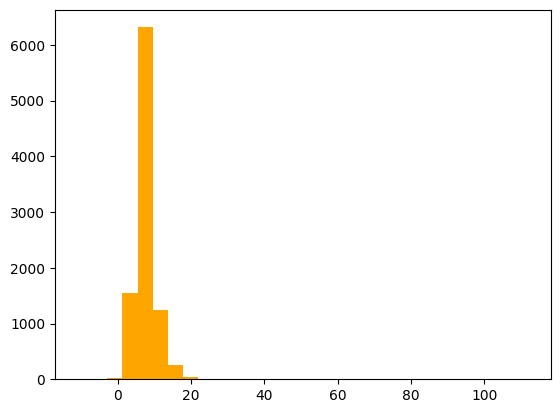

In [6]:
# identified some outliers that might be neccesary to deal with
# plot histogram of 
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

# identify outlier rows
outliers = X[X["Estimated_numerosity"] > 24]
print(f"Outliers {len(outliers)}")


Remaining rows: 9428


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.300e+01, 6.000e+00, 1.300e+01,
        1.920e+02, 1.335e+03, 1.888e+03, 1.827e+03, 1.665e+03, 9.360e+02,
        8.540e+02, 3.260e+02, 7.000e+01, 8.400e+01, 1.180e+02, 4.200e+01,
        3.600e+01, 4.000e+00, 1.000e+01, 2.000e+00, 3.000e+00, 3.000e+00]),
 array([-11.        ,  -9.83333333,  -8.66666667,  -7.5       ,
         -6.33333333,  -5.16666667,  -4.        ,  -2.83333333,
         -1.66666667,  -0.5       ,   0.66666667,   1.83333333,
          3.        ,   4.16666667,   5.33333333,   6.5       ,
          7.66666667,   8.83333333,  10.        ,  11.16666667,
         12.33333333,  13.5       ,  14.66666667,  15.83333333,
         17.        ,  18.16666667,  19.33333333,  20.5       ,
         21.66666667,  22.83333333,  24.        ]),
 <BarContainer object of 30 artists>)

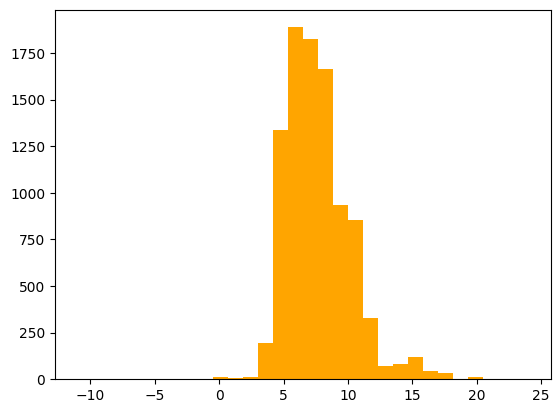

In [7]:

# remove rows where Estimated_numerosity > 24
X = X[X["Estimated_numerosity"] <= 24].copy()

# optional: check result
print(f"Remaining rows: {len(X)}")
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

In [8]:

# Encode entity (trial-level)
entity, entity_labels = pd.factorize(X["entity"])  # shape (n_trials,)
print(entity)

# Extract trial-level numerosity
x_stim = X["Presented_numerosity"].values
y_obs = X["Estimated_numerosity"].values
dose = X["dose"].values

# --- Build subject-level mapping ---
subject_info = X.drop_duplicates("S_ID").sort_values("S_ID")

# Map original S_ID → 0-based integer index (for PyMC)
subject_id_map = {subj: idx for idx, subj in enumerate(subject_info["S_ID"])}
subject_id = X["S_ID"].map(subject_id_map).values.astype(int)  # shape (n_trials,) → ✅ REPEATS ARE OK

# ✅ CORRECT: extract integer group codes at SUBJECT level
ph_type = subject_info["s_param_ph"].cat.codes.values  # shape (n_subjects,), dtype=int

# Optional: sanity checks
assert len(ph_type) == len(subject_info), "Group codes must be per subject"
assert subject_id.max() == len(ph_type) - 1, "subject_id must align with group codes"
assert set(np.unique(ph_type)) <= {0, 1, 2}, "Invalid group codes"

print(f"subject_id {len(subject_id)}")
print(f"ph_type {len(ph_type)}")

[0 0 0 ... 1 1 1]
subject_id 9428
ph_type 118


In [9]:
print(f"Building model ...")
model = build_hierarchical(
    x_stim,
    y_obs,
    subject_id,
    ph_type,
    entity
)


Building model ...


In [10]:

sample_config = {
    "draws": 2000,
    "tune": 1000,
    "target_accept": 0.9,
    "chains": 4
}

# Sampling
with model:
    prior_pred = pm.sample_prior_predictive(
        samples=5000,
        var_names=["y_pred_pp"]
    )

    trace = pm.sample(**sample_config)

    post_pred = pm.sample_posterior_predictive(trace, var_names=["y_pred"])

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/1629100513.py:10: UserWarning:

The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.

Sampling: [alpha_group_mu, alpha_group_sigma, alpha_subj, beta_group_mu, beta_group_sigma, beta_subj, delta_alpha_group_entity, delta_beta_group_entity, sigma_0_group, sigma_1_group, y_pp]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_group_mu, alpha_group_sigma, beta_group_mu, beta_group_sigma, alpha_subj, beta_subj, delta_alpha_group_entity, delta_beta_group_entity, sigma_0_group, sigma_1_group, y_pp, y_latent]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3007 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/1629100513.py:17: UserWarning:

The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.

Sampling: []


Output()

In [11]:
prior_pred

Inference data with groups:
	> prior

In [12]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [13]:
post_pred

Inference data with groups:
	> posterior_predictive

In [14]:
trace.extend(prior_pred)
trace.extend(post_pred)
idata = trace
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior

In [15]:
# TODO: save idata object hereø

## Prior Predictive


(47140000,)
(9428,)


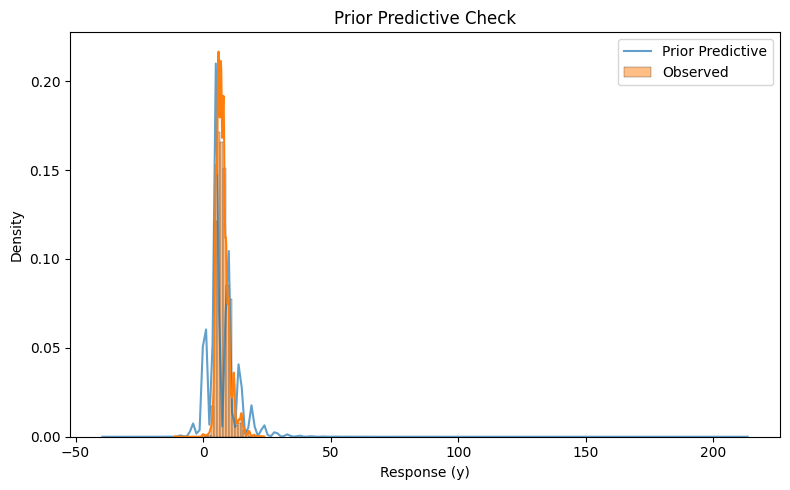

In [16]:
pc = prior_pred.prior.y_pred_pp.values # shape (1,5000,880), chain,samples,trials
pc = pc.flatten()
print(pc.shape)
print(y_obs.shape)

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(pc, label="Prior Predictive", alpha=0.7)
sns.histplot(y_obs, kde=True, stat="density", 
             label="Observed", alpha=0.5, color="C1", bins=30)

plt.xlabel("Response (y)")
plt.ylabel("Density")
plt.title("Prior Predictive Check")
plt.legend()
plt.tight_layout()
plt.show()

## Convergence & Sampling Diagnostics

In [19]:
az.style.use("arviz-whitegrid")

In [20]:

# Basic diagnostics
az.summary(idata, var_names=["alpha_group_mu", "beta_group_mu", "delta_alpha_group_entity"], round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_group_mu[NH],1.23,0.15,0.97,1.53,0.01,0.01,117.57,116.52,1.04
alpha_group_mu[PH],1.13,0.13,0.90,1.39,0.01,0.00,305.37,549.94,1.02
beta_group_mu[NH],0.96,0.07,0.84,1.09,0.00,0.00,373.40,823.56,1.01
beta_group_mu[PH],1.03,0.07,0.90,1.17,0.01,0.00,101.87,186.80,1.02
"delta_alpha_group_entity[NH, object]",-0.05,0.25,-0.40,0.48,0.11,0.05,7.59,26.75,1.50
"delta_alpha_group_entity[NH, human]",0.12,0.28,-0.45,0.51,0.12,0.06,7.38,56.83,1.53
"delta_alpha_group_entity[PH, object]",0.26,0.24,-0.24,0.62,0.10,0.05,7.48,37.61,1.52
"delta_alpha_group_entity[PH, human]",-0.19,0.23,-0.52,0.29,0.10,0.05,7.63,32.25,1.51


array([[<Axes: title={'center': 'alpha_group_mu'}>,
        <Axes: title={'center': 'alpha_group_mu'}>],
       [<Axes: title={'center': 'beta_group_mu'}>,
        <Axes: title={'center': 'beta_group_mu'}>],
       [<Axes: title={'center': 'delta_alpha_group_entity'}>,
        <Axes: title={'center': 'delta_alpha_group_entity'}>],
       [<Axes: title={'center': 'delta_beta_group_entity'}>,
        <Axes: title={'center': 'delta_beta_group_entity'}>],
       [<Axes: title={'center': 'sigma_0_group'}>,
        <Axes: title={'center': 'sigma_0_group'}>],
       [<Axes: title={'center': 'sigma_1_group'}>,
        <Axes: title={'center': 'sigma_1_group'}>]], dtype=object)

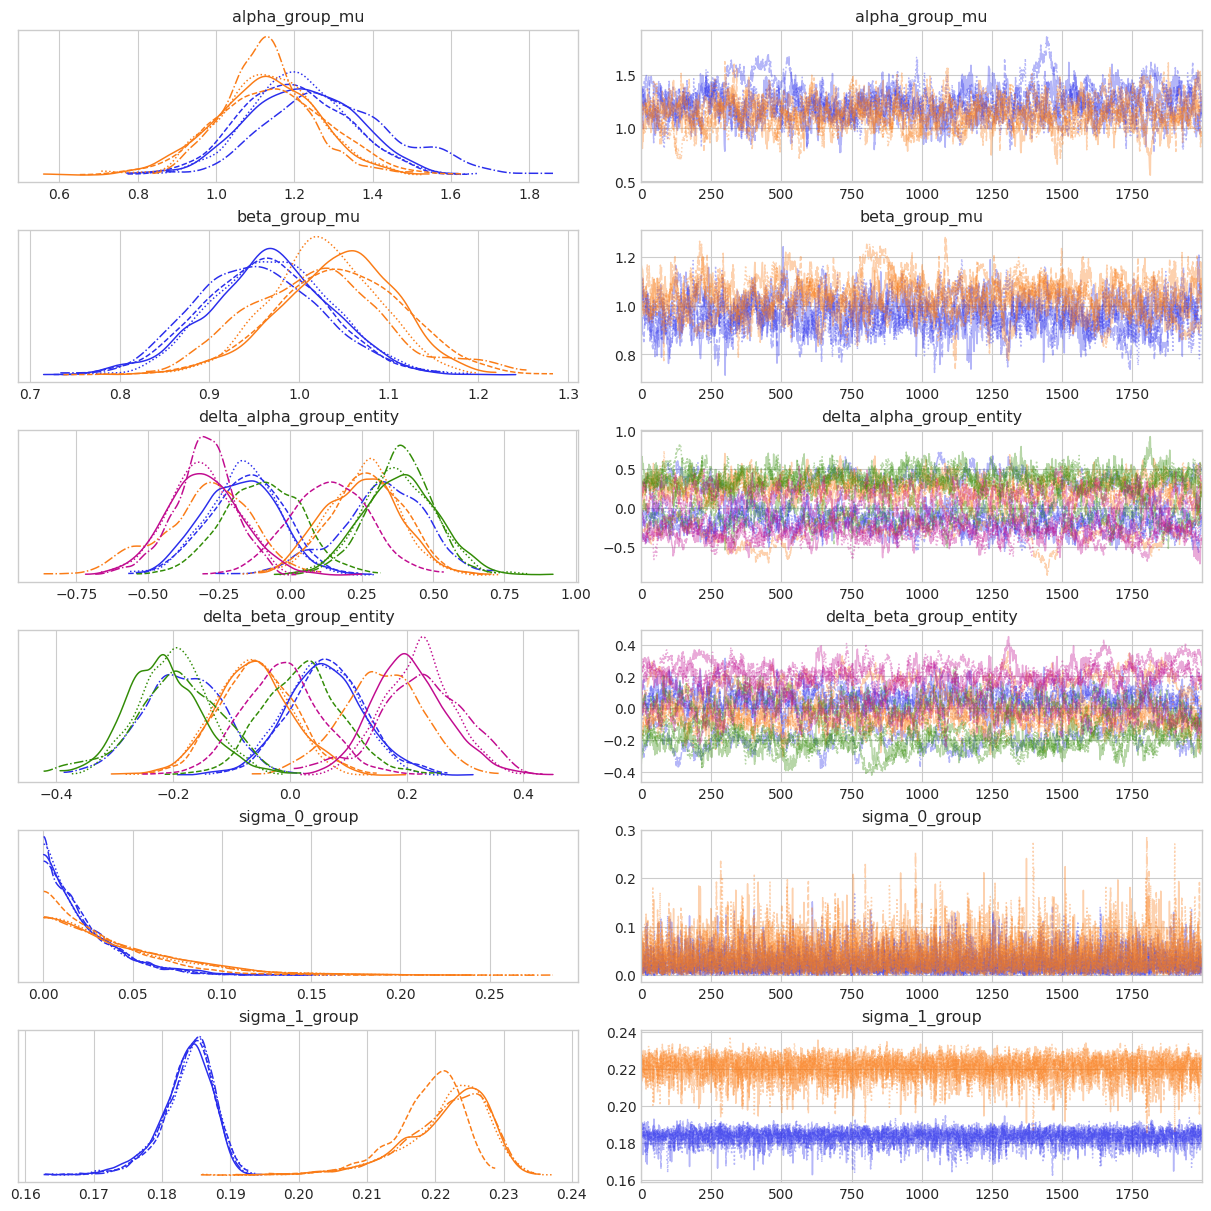

In [21]:
# Trace plots
az.plot_trace(idata, var_names=["alpha_group_mu", "beta_group_mu", "delta_alpha_group_entity", "delta_beta_group_entity", "sigma_0_group", "sigma_1_group"])

## Posterior Predictive

(47140000,)
(9428,)


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/855501415.py:16: UserWarning:

The figure layout has changed to tight



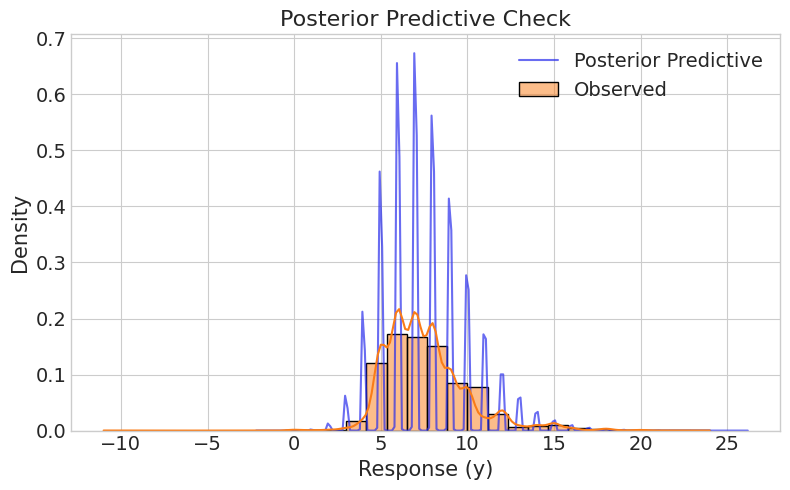

In [22]:
ppc = idata.posterior_predictive.y_pred.values # shape (4,2000,880), chain,samples,trials
ppc = ppc.flatten()
print(pc.shape)
print(y_obs.shape)

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(ppc, label="Posterior Predictive", alpha=0.7, color="C0")
sns.histplot(y_obs, kde=True, stat="density", 
             label="Observed", alpha=0.5, color="C1", bins=30)

plt.xlabel("Response (y)")
plt.ylabel("Density")
plt.title("Posterior Predictive Check")
plt.legend()
plt.tight_layout()
plt.show()

## Posterior Summaries of Key Group Parameters


In [23]:
# Group-level bias in scaling (alpha)
alpha_summary = az.summary(idata, var_names=["alpha_group_mu"], round_to=3)
print(alpha_summary)

# Group-level compression (beta)
beta_summary = az.summary(idata, var_names=["beta_group_mu"], round_to=3)
print(beta_summary)

# Human vs. object modulation
delta_alpha_summary = az.summary(idata, var_names=["delta_alpha_group_entity"], round_to=3)
print(delta_alpha_summary)

delta_beta_summary = az.summary(idata, var_names=["delta_beta_group_entity"], round_to=3)
print(delta_beta_summary)


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_group_mu[NH]  1.232  0.148   0.972    1.530      0.014    0.009   
alpha_group_mu[PH]  1.133  0.129   0.897    1.385      0.007    0.005   

                    ess_bulk  ess_tail  r_hat  
alpha_group_mu[NH]   117.573   116.524  1.045  
alpha_group_mu[PH]   305.374   549.945  1.016  
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_group_mu[NH]  0.963  0.069   0.836    1.092      0.004    0.002   
beta_group_mu[PH]  1.034  0.070   0.900    1.168      0.007    0.003   

                   ess_bulk  ess_tail  r_hat  
beta_group_mu[NH]   373.398   823.565  1.008  
beta_group_mu[PH]   101.871   186.796  1.020  
                                       mean     sd  hdi_3%  hdi_97%  \
delta_alpha_group_entity[NH, object] -0.045  0.250  -0.403    0.479   
delta_alpha_group_entity[NH, human]   0.119  0.278  -0.451    0.509   
delta_alpha_group_entity[PH, object]  0.262  0.244  -0.236    0.6

Noise summaries

In [24]:
sigma_summary = az.summary(idata, var_names=["sigma_0_group", "sigma_1_group"], round_to=3)
print(sigma_summary)

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_0_group[NH]  0.023  0.021   0.000    0.061      0.000    0.000   
sigma_0_group[PH]  0.040  0.036   0.000    0.103      0.001    0.001   
sigma_1_group[NH]  0.184  0.004   0.176    0.190      0.000    0.000   
sigma_1_group[PH]  0.221  0.006   0.210    0.232      0.001    0.000   

                   ess_bulk  ess_tail  r_hat  
sigma_0_group[NH]  5077.661  4618.938  1.002  
sigma_0_group[PH]  2450.776  4163.821  1.008  
sigma_1_group[NH]  2907.260  3955.418  1.002  
sigma_1_group[PH]    90.277  2958.003  1.035  


## Test Albert et al. Hypothesis: Group × Entity Interaction

In [25]:

# 1. Define the N you want to test (e.g., 8 items)
N_tests = range(0,10)

for N_test in N_tests:

    post = idata.posterior

    # 2. Extract Base Parameters
    alpha_mu = post["alpha_group_mu"]
    beta_mu = post["beta_group_mu"]

    # 3. Extract Interaction Parameters (Select specific Groups and Entities)
    # Note: Ensure you use the exact variable names from your trace
    delta_alpha = post["delta_alpha_group_entity"]
    delta_beta = post["delta_beta_group_entity"]

    # --- Calculate Net Parameters for STRONG Group (Human) ---
    # alpha_net = Group Mean + Group-Specific Human Adjustment
    alpha_strong_human = alpha_mu.sel(group="PH") + delta_alpha.sel(group="PH", entity_type="human")
    beta_strong_human  = beta_mu.sel(group="PH") + delta_beta.sel(group="PH", entity_type="human")

    # --- Calculate Net Parameters for NO Group (Human) ---
    alpha_no_human = alpha_mu.sel(group="NH") + delta_alpha.sel(group="NH", entity_type="human")
    beta_no_human  = beta_mu.sel(group="NH") + delta_beta.sel(group="NH", entity_type="human")

    # --- 4. CALCULATE THE ACTUAL ESTIMATES (Psychophysics) ---
    # Prediction = alpha * (N ** beta)
    pred_strong_human = alpha_strong_human * (N_test ** beta_strong_human)
    pred_no_human     = alpha_no_human * (N_test ** beta_no_human)

    # --- 5. Compare the Estimates ---
    # "Do Strong Hallucinators see MORE humans than Non-Hallucinators?"
    diff_perception = pred_strong_human - pred_no_human
    prob_hypothesis = (diff_perception > 0).mean().item()

    print(f"At N={N_test}:")
    print(f"Mean Est Strong: {pred_strong_human.mean().item():.2f}")
    print(f"Mean Est No:     {pred_no_human.mean().item():.2f}")
    print(f"Probability that PH > NH: {prob_hypothesis:.3f}")
    print(f"\n")

At N=0:
Mean Est Strong: 0.00
Mean Est No:     0.00
Probability that PH > NH: 0.000


At N=1:
Mean Est Strong: 0.94
Mean Est No:     1.35
Probability that PH > NH: 0.004


At N=2:
Mean Est Strong: 2.12
Mean Est No:     2.60
Probability that PH > NH: 0.067


At N=3:
Mean Est Strong: 3.43
Mean Est No:     3.82
Probability that PH > NH: 0.180


At N=4:
Mean Est Strong: 4.82
Mean Est No:     5.02
Probability that PH > NH: 0.312


At N=5:
Mean Est Strong: 6.28
Mean Est No:     6.21
Probability that PH > NH: 0.531


At N=6:
Mean Est Strong: 7.80
Mean Est No:     7.39
Probability that PH > NH: 0.777


At N=7:
Mean Est Strong: 9.38
Mean Est No:     8.56
Probability that PH > NH: 0.899


At N=8:
Mean Est Strong: 11.00
Mean Est No:     9.73
Probability that PH > NH: 0.949


At N=9:
Mean Est Strong: 12.66
Mean Est No:     10.89
Probability that PH > NH: 0.966




A theoretical investigation based on summary mean values into the overestimation of human numerosity in parkinsons patients.

In [26]:
alpha_summary = az.summary(idata, var_names=["alpha_group_mu"], round_to=3)
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_group_mu[NH],1.232,0.148,0.972,1.530,0.014,0.009,117.573,116.524,1.045
alpha_group_mu[PH],1.133,0.129,0.897,1.385,0.007,0.005,305.374,549.945,1.016


In [27]:
az.summary(idata, var_names=["delta_alpha_group_entity", "delta_beta_group_entity"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"delta_alpha_group_entity[NH, object]",-0.045,0.250,-0.403,0.479,0.105,0.055,7.585,26.752,1.496
"delta_alpha_group_entity[NH, human]",0.119,0.278,-0.451,0.509,0.121,0.062,7.384,56.826,1.528
"delta_alpha_group_entity[PH, object]",0.262,0.244,-0.236,0.622,0.105,0.052,7.480,37.607,1.524
"delta_alpha_group_entity[PH, human]",-0.194,0.228,-0.522,0.286,0.096,0.046,7.629,32.245,1.508
"delta_beta_group_entity[NH, object]",-0.001,0.124,-0.262,0.174,0.053,0.026,7.379,31.283,1.521
"delta_beta_group_entity[NH, human]",-0.007,0.115,-0.175,0.231,0.048,0.023,7.571,29.854,1.498
"delta_beta_group_entity[PH, object]",-0.147,0.118,-0.322,0.099,0.049,0.023,7.341,33.624,1.519
"delta_beta_group_entity[PH, human]",0.159,0.121,-0.085,0.345,0.051,0.024,7.323,34.195,1.521


Plot the posterior predictive curves given the mean values of 

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/4222810125.py:101: UserWarning:

The figure layout has changed to tight



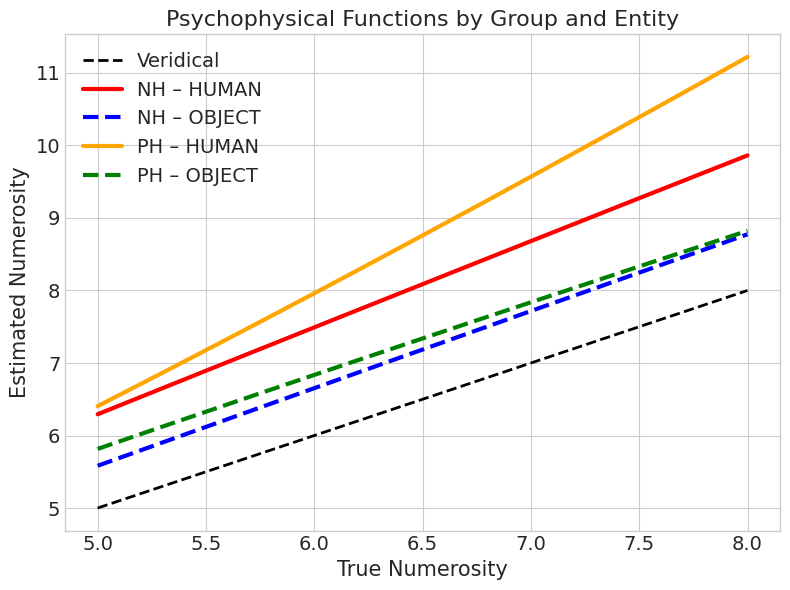

In [28]:


# Create a range of N (e.g., 5 to 8)
n_range = np.linspace(5, 8, 50)

# ---------- Base alpha (group-level) ----------
alpha_nh_base = alpha_summary["mean"]["alpha_group_mu[NH]"]
alpha_ph_base = alpha_summary["mean"]["alpha_group_mu[PH]"]

# ---------- Base beta (group-level) ----------
beta_nh_base = beta_summary["mean"]["beta_group_mu[NH]"]
beta_ph_base = beta_summary["mean"]["beta_group_mu[PH]"]

# DELTA ALPHA
# ---------- NH group ----------
delta_alpha_nh_o = delta_alpha_summary["mean"]["delta_alpha_group_entity[NH, object]"]
delta_alpha_nh_h = delta_alpha_summary["mean"]["delta_alpha_group_entity[NH, human]"]

# ---------- PH group ----------
delta_alpha_ph_o = delta_alpha_summary["mean"]["delta_alpha_group_entity[PH, object]"]
delta_alpha_ph_h = delta_alpha_summary["mean"]["delta_alpha_group_entity[PH, human]"]

# DELTA BETA
# ---------- NH group ----------
delta_beta_nh_o = delta_beta_summary["mean"]["delta_beta_group_entity[NH, object]"]
delta_beta_nh_h = delta_beta_summary["mean"]["delta_beta_group_entity[NH, human]"]

# ---------- PH group ----------
delta_beta_ph_o = delta_beta_summary["mean"]["delta_beta_group_entity[PH, object]"]
delta_beta_ph_h = delta_beta_summary["mean"]["delta_beta_group_entity[PH, human]"]

# Stimulus range
n_range = np.linspace(5, 8, 200)

# -------------------------
# Group-level base params
# -------------------------
params_base = {
    "NH": {"alpha": alpha_nh_base, "beta": beta_nh_base},
    "PH": {"alpha": alpha_ph_base, "beta": beta_ph_base},
}

# ----------------------------------
# Group × entity deviations
# (posterior means, for example)
# ----------------------------------
delta_params = {
    "NH": {
        "human":  {"alpha": delta_alpha_nh_h, "beta": delta_beta_nh_h},
        "object": {"alpha": delta_alpha_nh_o, "beta": delta_beta_nh_o},
    },
    "PH": {
        "human":  {"alpha": delta_alpha_ph_h, "beta": delta_beta_ph_h},
        "object": {"alpha": delta_alpha_ph_o, "beta": delta_beta_ph_o},
    },
}

def psychophysical_curve(n, alpha_base, beta_base, delta_alpha, delta_beta):
    alpha = alpha_base + delta_alpha
    beta  = beta_base  + delta_beta
    return alpha * (n ** beta)

plt.figure(figsize=(8, 6))

# Veridical reference
plt.plot(n_range, n_range, "k--", linewidth=2, label="Veridical")

colors = {
    ("NH", "human"): "red",
    ("NH", "object"): "blue",
    ("PH", "human"): "orange",
    ("PH", "object"): "green",
}

linestyles = {
    "human": "-",
    "object": "--",
}

for group in ["NH", "PH"]:
    for entity in ["human", "object"]:
        y = psychophysical_curve(
            n_range,
            alpha_base=params_base[group]["alpha"],
            beta_base=params_base[group]["beta"],
            delta_alpha=delta_params[group][entity]["alpha"],
            delta_beta=delta_params[group][entity]["beta"],
        )

        plt.plot(
            n_range,
            y,
            color=colors[(group, entity)],
            linestyle=linestyles[entity],
            linewidth=3,
            label=f"{group} – {entity.upper()}",
        )

plt.xlabel("True Numerosity")
plt.ylabel("Estimated Numerosity")
plt.title("Psychophysical Functions by Group and Entity")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/1942915363.py:23: UserWarning:

The figure layout has changed to tight



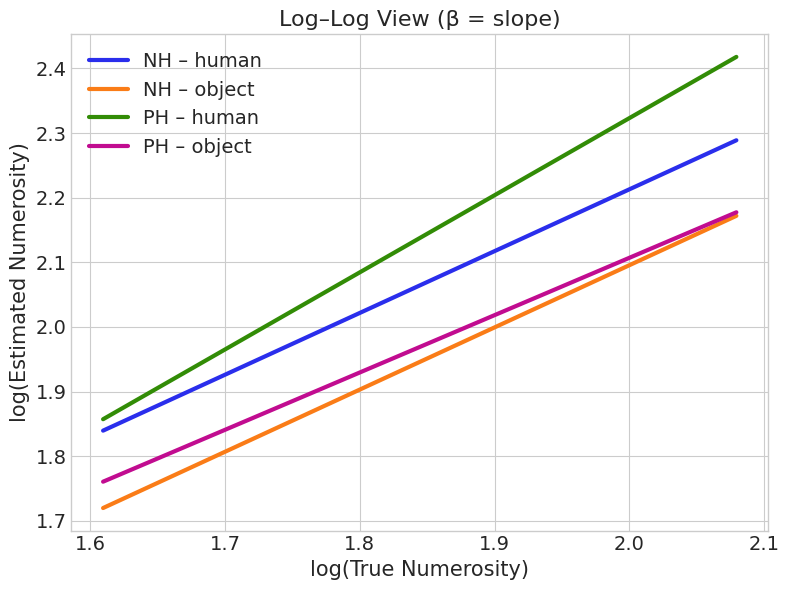

In [29]:
plt.figure(figsize=(8, 6))

for group in ["NH", "PH"]:
    for entity in ["human", "object"]:
        y = psychophysical_curve(
            n_range,
            params_base[group]["alpha"],
            params_base[group]["beta"],
            delta_params[group][entity]["alpha"],
            delta_params[group][entity]["beta"],
        )
        plt.plot(
            np.log(n_range),
            np.log(y),
            linewidth=3,
            label=f"{group} – {entity}",
        )

plt.xlabel("log(True Numerosity)")
plt.ylabel("log(Estimated Numerosity)")
plt.title("Log–Log View (β = slope)")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/1855611432.py:113: UserWarning:

The figure layout has changed to tight



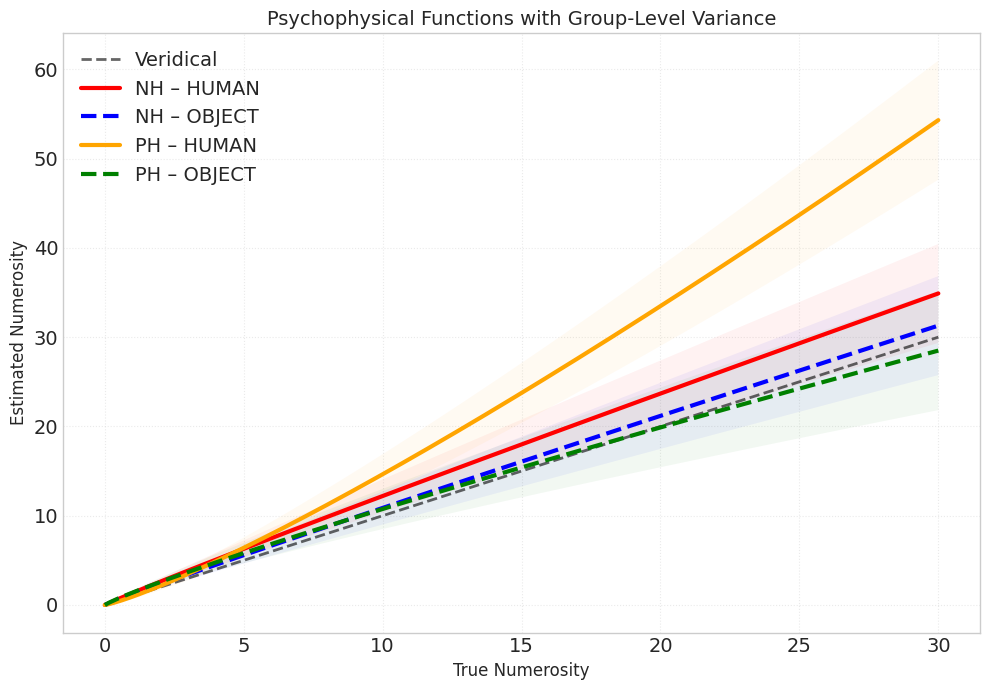

In [30]:
# -------------------------
# 1. Retrieve Sigma Params
# -------------------------
# Assuming you have a dictionary named 'sigma_summary' similar to alpha_summary
# If your variable is named differently, update 'sigma_summary' below.

# ---------- NH group ----------
sigma0_nh = sigma_summary["mean"]["sigma_0_group[NH]"]
sigma1_nh = sigma_summary["mean"]["sigma_1_group[NH]"]

# ---------- PH group ----------
sigma0_ph = sigma_summary["mean"]["sigma_0_group[PH]"]
sigma1_ph = sigma_summary["mean"]["sigma_1_group[PH]"]

# Organize into dictionary for easy loop access
params_sigma = {
    "NH": {"s0": sigma0_nh, "s1": sigma1_nh},
    "PH": {"s0": sigma0_ph, "s1": sigma1_ph},
}

# -------------------------
# Setup Data
# -------------------------
n_range = np.linspace(0, 30, 200)

params_base = {
    "NH": {"alpha": alpha_nh_base, "beta": beta_nh_base},
    "PH": {"alpha": alpha_ph_base, "beta": beta_ph_base},
}

delta_params = {
    "NH": {
        "human":  {"alpha": delta_alpha_nh_h, "beta": delta_beta_nh_h},
        "object": {"alpha": delta_alpha_nh_o, "beta": delta_beta_nh_o},
    },
    "PH": {
        "human":  {"alpha": delta_alpha_ph_h, "beta": delta_beta_ph_h},
        "object": {"alpha": delta_alpha_ph_o, "beta": delta_beta_ph_o},
    },
}

def psychophysical_curve(n, alpha_base, beta_base, delta_alpha, delta_beta):
    alpha = alpha_base + delta_alpha
    beta  = beta_base  + delta_beta
    return alpha * (n ** beta)

# -------------------------
# Plotting
# -------------------------
plt.figure(figsize=(10, 7))

# Veridical reference
plt.plot(n_range, n_range, "k--", linewidth=2, label="Veridical", alpha=0.6)

colors = {
    ("NH", "human"): "red",
    ("NH", "object"): "blue",
    ("PH", "human"): "orange",
    ("PH", "object"): "green",
}

linestyles = {
    "human": "-",
    "object": "--",
}

for group in ["NH", "PH"]:
    # 2. Calculate Sigma for this Group
    # Formula: sigma = sigma_0 + sigma_1 * n
    # This represents the Standard Deviation of the estimates
    s0 = params_sigma[group]["s0"]
    s1 = params_sigma[group]["s1"]
    
    # The spread of the error increases (or decreases) as N increases
    sigma_vec = s0 + s1 * n_range

    for entity in ["human", "object"]:
        # Calculate Mean Curve (y)
        y = psychophysical_curve(
            n_range,
            alpha_base=params_base[group]["alpha"],
            beta_base=params_base[group]["beta"],
            delta_alpha=delta_params[group][entity]["alpha"],
            delta_beta=delta_params[group][entity]["beta"],
        )
        
        # Plot the Mean Line
        plt.plot(
            n_range,
            y,
            color=colors[(group, entity)],
            linestyle=linestyles[entity],
            linewidth=3,
            label=f"{group} – {entity.upper()}",
        )
        
        # 3. Add Variance Bands
        # Plotting Mean +/- 1 Standard Deviation
        plt.fill_between(
            n_range, 
            y - sigma_vec, # Lower bound
            y + sigma_vec, # Upper bound
            color=colors[(group, entity)], 
            alpha=0.05,    # Low opacity to see overlap
            edgecolor=None # Remove edge lines on the fill
        )

plt.xlabel("True Numerosity", fontsize=12)
plt.ylabel("Estimated Numerosity", fontsize=12)
plt.title("Psychophysical Functions with Group-Level Variance", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

Detected entity labels: ['object' 'human']


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_20999/3334890079.py:96: UserWarning:

The figure layout has changed to tight



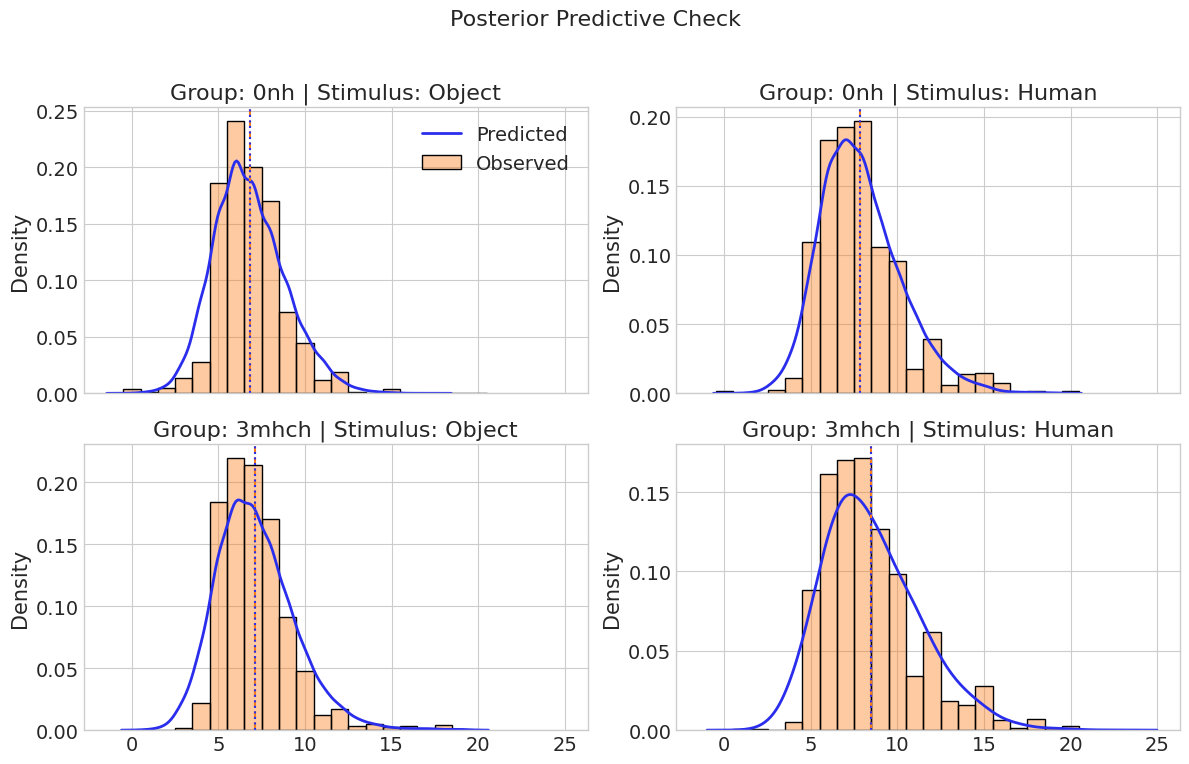

In [31]:
# --- 1. PREPARE MAPPING ---
# Detect what string/value corresponds to "Human" vs "Object" in your DataFrame
# Adjust these strings if your print output above shows something different (e.g. 'Human' vs 'human')
unique_entities = X["entity"].unique()
print(f"Detected entity labels: {unique_entities}")

# Create a mapping for the loop. 
# We assume the model treated 0=Object, 1=Human. 
# We need to know which string in X corresponds to which integer.
# commonly:
if "human" in unique_entities or "Human" in unique_entities:
    # Dictionary mapping: {Model_Int: DataFrame_Value}
    # Adjust the dictionary values based on your debug print!
    entity_map = {
        0: "object",  # or "Object"
        1: "human"    # or "Human"
    }
else:
    # If they are already integers 0 and 1
    entity_map = {0: 0, 1: 1}

# Flatten predictions
y_pred_all = idata.posterior_predictive.y_pred.values
n_chains, n_draws, n_trials = y_pred_all.shape
y_pred_flat = y_pred_all.reshape(n_chains * n_draws, n_trials)

# Ensure groups are sorted consistently
groups = sorted(X["s_param_ph"].unique())

# --- 2. PLOT ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
fig.suptitle("Posterior Predictive Check", fontsize=16)

color_pred = "C0"  # Blue
color_obs = "C1"   # Orange

for i, group in enumerate(groups):
    for j, ent_int in enumerate([0, 1]): # Loop over model integers
        ax = axes[i, j]
        
        # Get the actual value used in the dataframe
        df_ent_value = entity_map[ent_int]
        
        # Create Mask using the DataFrame value
        mask = (X["s_param_ph"] == group) & (X["entity"] == df_ent_value)
        
        # Debugging check inside loop
        if mask.sum() == 0:
            ax.text(0.5, 0.5, f"NO DATA\nGroup: {group}\nEntity: {df_ent_value}", 
                    ha='center', va='center', color='red')
            continue
            
        # Get Data
        # Ensure y_obs is a numpy array aligned with X
        # If y_obs is a Series, use y_obs.values[mask]
        obs_subset = y_obs[mask] if isinstance(y_obs, np.ndarray) else y_obs.values[mask]
        
        pred_subset = y_pred_flat[:, mask]
        pred_subset_flat = pred_subset.flatten()
        
        # Plot Observed
        sns.histplot(
            obs_subset, 
            stat="density", 
            bins=np.arange(0, 22) - 0.5, 
            color=color_obs, 
            alpha=0.4, 
            label="Observed", 
            ax=ax
        )
        
        # Plot Predicted (Subsampled for speed)
        plot_sample_size = min(len(pred_subset_flat), 10000)
        rng = np.random.default_rng(42)
        subset_for_kde = rng.choice(pred_subset_flat, size=plot_sample_size, replace=False)
        
        sns.kdeplot(
            subset_for_kde, 
            color=color_pred, 
            linewidth=2, 
            label="Predicted", 
            ax=ax,
            bw_adjust=1.5
        )
        
        # Labels
        ent_label = "Human" if ent_int == 1 else "Object"
        group_label = str(group)
        ax.set_title(f"Group: {group_label} | Stimulus: {ent_label}")
        
        # Mean lines
        ax.axvline(np.mean(obs_subset), color=color_obs, linestyle="--")
        ax.axvline(np.mean(pred_subset_flat), color=color_pred, linestyle=":")

axes[0,0].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Entity-Specific Effects

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

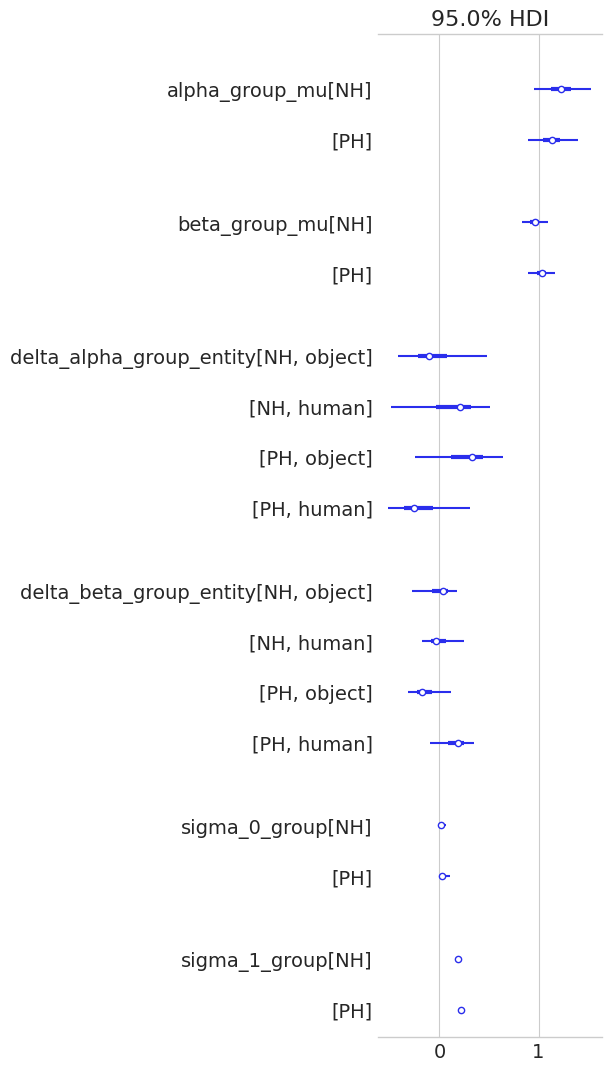

In [32]:
az.plot_forest(
    idata,
    var_names=["alpha_group_mu", "beta_group_mu", "delta_alpha_group_entity", "delta_beta_group_entity", "sigma_0_group", "sigma_1_group"],
    combined=True,
    hdi_prob=0.95
)

# Subject level parameters